In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)

if not os.path.exists('results'):
    os.mkdir('results')

if not os.path.exists('results/pca'):
    os.mkdir('results/pca')

if not os.path.exists('results/no_pca'):
    os.mkdir('results/no_pca')

## Classic Machine Learning Techniques

In [3]:
is_pca = False

if is_pca:
    path = 'runs/classicMl/pca/'
    results_path = 'results/pca/'
else:
    path = 'runs/classicMl/no_pca/'
    results_path = 'results/no_pca/'

In [4]:
seed = 42
np.random.seed(seed)

df = pd.read_csv('dataset.csv')
display(df.head())
print(f'Number of samples: {df.shape[0]}')

,rating_mean,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.893708,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0,0,0,0,0,0,0,0,0,0
1,3.251527,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0,0,0,0,0,0,0,0,0,0
2,3.142028,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0,0,0,0,0,1,0,0,0,0
3,2.853547,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0,0,0,0,0,1,0,0,0,0
4,3.058434,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0,0,0,0,0,0,0,0,0,0


Number of samples: 13798


### Data Preprocessing

In [5]:
X = df.drop('rating_mean', axis=1)
y = df['rating_mean']

# Train Test and Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

print('Number of training samples:', X_train.shape)
print('Number of testing samples:', X_test.shape)
print('Number of validation samples:', X_val.shape)

Number of training samples: (9934, 1148)
Number of testing samples: (2760, 1148)
Number of validation samples: (1104, 1148)


In [6]:
if is_pca:
    print("Applying PCA...")
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)
    print(f'Number of features after PCA: {X_train.shape[1]}')
else:
    print("PCA is not applied")

PCA is not applied


# Models
### Linear Regression

In [7]:
writer = SummaryWriter(path + 'linear_regression')

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

writer.add_scalar('Loss', mse)
writer.flush()

print('Linear Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

open(results_path + 'linear_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}')

Linear Regression Results:
Mean Square Error: 0.005334505742097179
R2 Score: 0.976349898145375


67

### Ridge Regression

In [8]:
from sklearn.linear_model import Ridge

alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:

    # Tensorboard
    dir_name = f'alpha={alpha}'
    writer = SummaryWriter(path + 'ridge_regression/' + dir_name)

    i += 1
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X_train, y_train)
    y_pred = ridge_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    writer.add_scalar('Loss', mse, alpha)
    writer.add_hparams({'alpha': alpha}, {'mse': mse})
    writer.flush()

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = ridge_regressor

    results.append((i, alpha, mse))

    print(f'Iteration: {i} | Alpha: {alpha} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Ridge Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | Alpha: 0.001 | MSE: 0.0051

Iteration: 2 | Alpha: 0.01 | MSE: 0.0051

Iteration: 3 | Alpha: 0.1 | MSE: 0.0051

Iteration: 4 | Alpha: 0.5 | MSE: 0.0051

Iteration: 5 | Alpha: 1 | MSE: 0.0051

Iteration: 6 | Alpha: 5 | MSE: 0.0051

Iteration: 7 | Alpha: 10 | MSE: 0.0052

Ridge Regression Best Results:
Alpha: 1
Mean Square Error: 0.005089884468570583
R2 Score: 0.9767023984998882


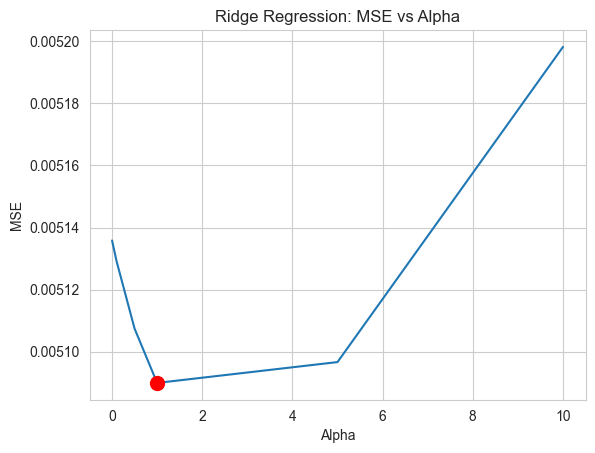

In [9]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])
sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

results.to_csv(results_path + 'ridge_regression.csv', index=False)

### Lasso Regression

In [10]:
from sklearn.linear_model import Lasso

alphas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:

    # Tensorboard
    dir_name = f'alpha={alpha}'
    writer = SummaryWriter(path + 'lasso_regression/' + dir_name)

    i += 1
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, y_train)
    y_pred = lasso_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    writer.add_scalar('Loss', mse, alpha)
    writer.add_hparams({'alpha': alpha}, {'mse': mse})
    writer.flush()

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = lasso_regressor

    results.append((i, alpha, mse))

    print(f'Iteration: {i} | Alpha: {alpha} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Lasso Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | Alpha: 0.01 | MSE: 0.0317

Iteration: 2 | Alpha: 0.001 | MSE: 0.0104

Iteration: 3 | Alpha: 0.0001 | MSE: 0.0054

Iteration: 4 | Alpha: 1e-05 | MSE: 0.0051

Iteration: 5 | Alpha: 1e-06 | MSE: 0.0053

Lasso Regression Best Results:
Alpha: 1e-05
Mean Square Error: 0.005098180158555444
R2 Score: 0.9765532943400839


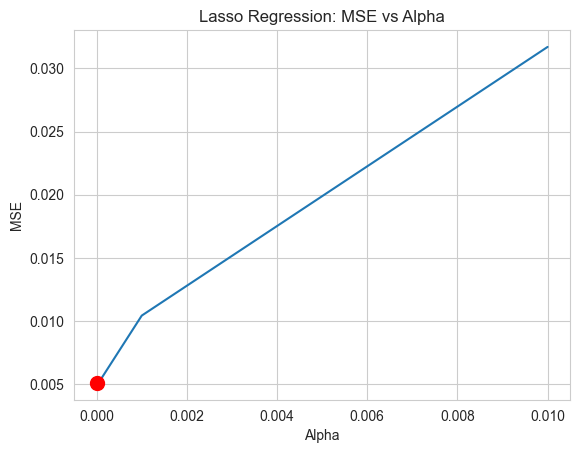

In [11]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

results.to_csv(results_path + 'lasso_regression.csv', index=False)

### Elastic Net Regression

In [12]:
from sklearn.linear_model import ElasticNet

alphas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:

    # Tensorboard
    dir_name = f'alpha={alpha}'
    writer = SummaryWriter(path + 'elastic_net_regression/' + dir_name)

    i += 1
    elastic_net_regressor = ElasticNet(alpha=alpha)
    elastic_net_regressor.fit(X_train, y_train)
    y_pred = elastic_net_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    writer.add_scalar('Loss', mse, alpha)
    writer.add_hparams({'alpha': alpha}, {'mse': mse})
    writer.flush()

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = elastic_net_regressor

    results.append((i, alpha, mse))

    print(f'Iteration: {i} | Alpha: {alpha} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Elastic Net Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | Alpha: 0.01 | MSE: 0.0217

Iteration: 2 | Alpha: 0.001 | MSE: 0.0081

Iteration: 3 | Alpha: 0.0001 | MSE: 0.0052

Iteration: 4 | Alpha: 1e-05 | MSE: 0.0052

Iteration: 5 | Alpha: 1e-06 | MSE: 0.0053

Elastic Net Regression Best Results:
Alpha: 0.0001
Mean Square Error: 0.00516709167911393
R2 Score: 0.976989940432127


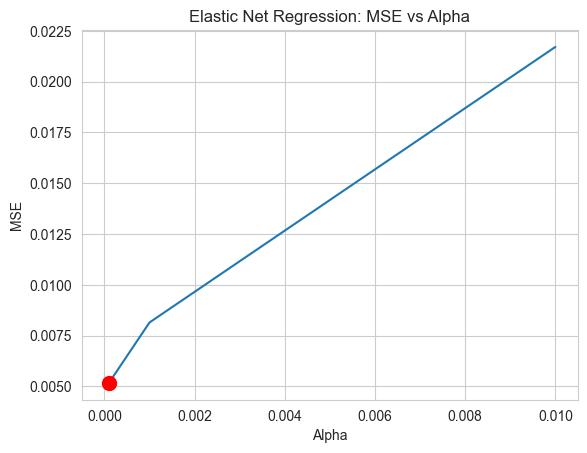

In [13]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Elastic Net Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

results.to_csv(results_path + 'elastic_net_regression.csv', index=False)

### Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor
import itertools

n_est = [100, 150, 200, 250]
criterion = ['squared_error', 'friedman_mse', 'poisson']

best_mse = None
best_estimator = None
best_model = None
best_criterion = None

results = []

i = 0
for n_est, criterion in itertools.product(n_est, criterion):

    # Tensorboard
    dir_name = f'n_est={n_est}, criterion={criterion}'
    writer = SummaryWriter(path + 'random_forest_regressor/' + dir_name)

    i += 1
    rf_regressor = RandomForestRegressor(n_estimators=n_est, criterion=criterion, random_state=seed)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    writer.add_scalar('Loss', mse, n_est)
    writer.add_hparams({'n_est': n_est, 'criterion': criterion}, {'mse': mse})
    writer.flush()

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_estimator = n_est
        best_model = rf_regressor
        best_criterion = criterion

    results.append((i, n_est, criterion, mse))

    print(f'Iteration: {i} | N-Estimators: {n_est} | Criterion: {criterion} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Random Forest Regressor Best Results:')
print('N Trees:', best_estimator)
print('Criterion:', best_criterion)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | N-Estimators: 100 | Criterion: squared_error | MSE: 0.0132

Iteration: 2 | N-Estimators: 100 | Criterion: friedman_mse | MSE: 0.0131

Iteration: 3 | N-Estimators: 100 | Criterion: poisson | MSE: 0.0134

Iteration: 4 | N-Estimators: 150 | Criterion: squared_error | MSE: 0.0131

Iteration: 5 | N-Estimators: 150 | Criterion: friedman_mse | MSE: 0.0131

Iteration: 6 | N-Estimators: 150 | Criterion: poisson | MSE: 0.0133

Iteration: 7 | N-Estimators: 200 | Criterion: squared_error | MSE: 0.0131

Iteration: 8 | N-Estimators: 200 | Criterion: friedman_mse | MSE: 0.0131

Iteration: 9 | N-Estimators: 200 | Criterion: poisson | MSE: 0.0133

Iteration: 10 | N-Estimators: 250 | Criterion: squared_error | MSE: 0.0131

Iteration: 11 | N-Estimators: 250 | Criterion: friedman_mse | MSE: 0.0131

Iteration: 12 | N-Estimators: 250 | Criterion: poisson | MSE: 0.0133

Random Forest Regressor Best Results:
N Trees: 200
Criterion: friedman_mse
Mean Square Error: 0.013070884638130288
R2 Score: 

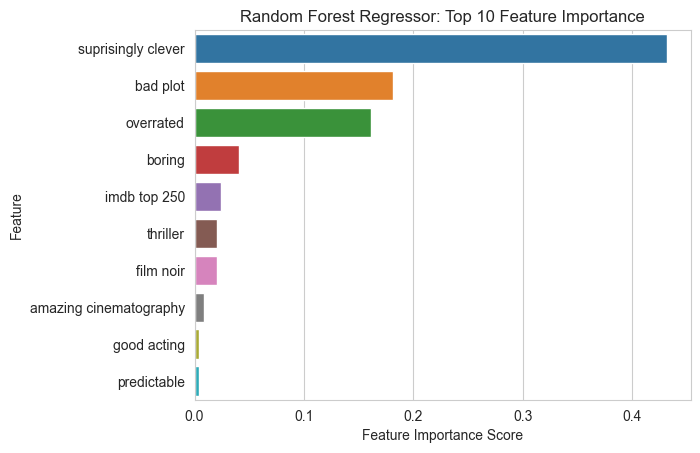

In [15]:
if not is_pca:
    rankVar = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    sns.barplot(x=rankVar[:10], y=rankVar.index[:10])
    plt.title('Random Forest Regressor: Top 10 Feature Importance')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature')
    plt.show()


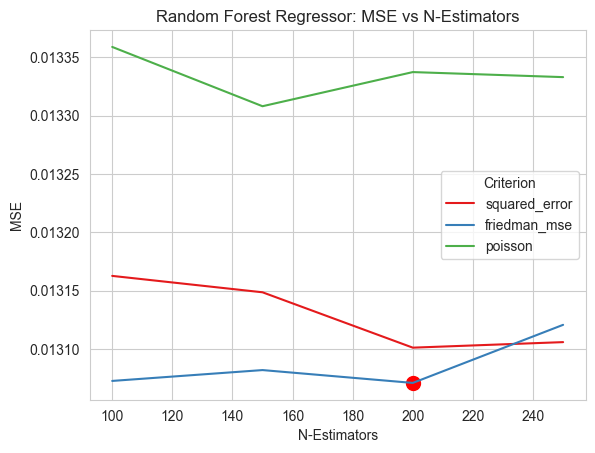

In [16]:
results = pd.DataFrame(results, columns=['Iteration', 'N-Estimators', 'Criterion', 'MSE'])

sns.lineplot(x='N-Estimators', y='MSE', hue='Criterion', data=results, palette='Set1', markers='o')
plt.xlabel('N-Estimators')
plt.ylabel('MSE')
plt.title('Random Forest Regressor: MSE vs N-Estimators')
plt.scatter(best_estimator, best_mse, color='red', marker='o', s=100)
plt.show()

results.to_csv(results_path + 'random_forest_regressor.csv', index=False)

### Support Vector Regressor

In [20]:
from sklearn.svm import SVR
import itertools

c = [0.001, 0.01, 0.1, 1]
epsilon = [0.001, 0.01, 0.1, 1]
kernel = ['linear', 'poly', 'rbf']

best_mse = None
best_c = None
best_epsilon = None
best_kernel = None
best_model = None

results = []

i = 0

for c_value, epsilon_value, kernel_value in itertools.product(c, epsilon, kernel):

    # Tensorboard
    dir_name = f'c={c_value}, epsilon={epsilon_value}, kernel={kernel_value}'
    writer = SummaryWriter(path + 'support_vector_regressor/' + dir_name)

    i += 1
    svr_regressor = SVR(C=c_value, epsilon=epsilon_value, kernel=kernel_value)
    svr_regressor.fit(X_train, y_train)
    y_pred = svr_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    writer.add_scalar('Loss', mse, c_value)
    writer.add_hparams({'c': c_value, 'epsilon': epsilon_value, 'kernel': kernel_value}, {'mse':mse})
    writer.flush()

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_c = c_value
        best_epsilon = epsilon_value
        best_kernel = kernel_value
        best_model = svr_regressor

    results.append((i, c_value, epsilon_value, kernel_value, mse))

    print(f'Iteration: {i} | C: {c_value} | Epsilon: {epsilon_value} | Kernel: {kernel_value} | MSE: {mse:.4f}\n')

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Support Vector Regression Best Results:')
print('C:', best_c)
print('Epsilon:', best_epsilon)
print('Kernel:', best_kernel)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | C: 0.001 | Epsilon: 0.001 | Kernel: linear | MSE: 0.0082

Iteration: 2 | C: 0.001 | Epsilon: 0.001 | Kernel: poly | MSE: 0.0806

Iteration: 3 | C: 0.001 | Epsilon: 0.001 | Kernel: rbf | MSE: 0.1079

Iteration: 4 | C: 0.001 | Epsilon: 0.01 | Kernel: linear | MSE: 0.0083

Iteration: 5 | C: 0.001 | Epsilon: 0.01 | Kernel: poly | MSE: 0.0807

Iteration: 6 | C: 0.001 | Epsilon: 0.01 | Kernel: rbf | MSE: 0.1080

Iteration: 7 | C: 0.001 | Epsilon: 0.1 | Kernel: linear | MSE: 0.0107

Iteration: 8 | C: 0.001 | Epsilon: 0.1 | Kernel: poly | MSE: 0.0831

Iteration: 9 | C: 0.001 | Epsilon: 0.1 | Kernel: rbf | MSE: 0.1105

Iteration: 10 | C: 0.001 | Epsilon: 1 | Kernel: linear | MSE: 0.2563

Iteration: 11 | C: 0.001 | Epsilon: 1 | Kernel: poly | MSE: 0.2826

Iteration: 12 | C: 0.001 | Epsilon: 1 | Kernel: rbf | MSE: 0.2675

Iteration: 13 | C: 0.01 | Epsilon: 0.001 | Kernel: linear | MSE: 0.0054

Iteration: 14 | C: 0.01 | Epsilon: 0.001 | Kernel: poly | MSE: 0.0242

Iteration: 15 | C:

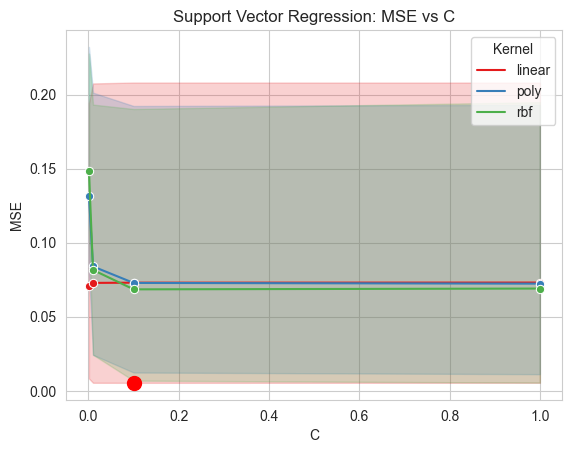

In [21]:
results = pd.DataFrame(results, columns=['Iteration', 'C', 'Epsilon', 'Kernel', 'MSE'])

sns.lineplot(x='C', y='MSE', hue='Kernel', data=results, palette='Set1', marker='o')
plt.xlabel('C')
plt.ylabel('MSE')
plt.title('Support Vector Regression: MSE vs C')
plt.scatter(best_c, best_mse, color='red', marker='o', s=100)
plt.show()

results.to_csv(results_path + 'support_vector_regressor.csv', index=False)

### K-Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19]
weights = ['uniform', 'distance']

best_mse = None
best_n_neighbors = None
best_model = None
best_weight = None

results = []

i = 0

for n, w in itertools.product(n_neighbors, weights):

    # Tensorboard
    dir_name = f'n={n}, weight={w}'
    writer = SummaryWriter(path + 'k_nearest_neighbors/' + dir_name)

    i += 1
    knn_regressor = KNeighborsRegressor(n_neighbors=n, weights=w)
    knn_regressor.fit(X_train, y_train)
    y_pred = knn_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    writer.add_scalar('Loss', mse, n)
    writer.add_hparams({'n': n, 'weight': w}, {'mse':mse})
    writer.flush()

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_n_neighbors = n
        best_model = knn_regressor
        best_weight = w

    results.append((i, n, w, mse))

    print(f'Iteration: {i} | N: {n} | Weight: {w} | MSE: {mse:.4f}\n')


y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('K-Nearest Neighbors Best Results:')
print('N:', best_n_neighbors)
print('Weight:', best_weight)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 | N: 3 | Weight: uniform | MSE: 0.0539

Iteration: 2 | N: 3 | Weight: distance | MSE: 0.0536

Iteration: 3 | N: 5 | Weight: uniform | MSE: 0.0479

Iteration: 4 | N: 5 | Weight: distance | MSE: 0.0474

Iteration: 5 | N: 7 | Weight: uniform | MSE: 0.0468

Iteration: 6 | N: 7 | Weight: distance | MSE: 0.0463

Iteration: 7 | N: 9 | Weight: uniform | MSE: 0.0456

Iteration: 8 | N: 9 | Weight: distance | MSE: 0.0451

Iteration: 9 | N: 11 | Weight: uniform | MSE: 0.0452

Iteration: 10 | N: 11 | Weight: distance | MSE: 0.0447

Iteration: 11 | N: 13 | Weight: uniform | MSE: 0.0455

Iteration: 12 | N: 13 | Weight: distance | MSE: 0.0449

Iteration: 13 | N: 15 | Weight: uniform | MSE: 0.0455

Iteration: 14 | N: 15 | Weight: distance | MSE: 0.0449

Iteration: 15 | N: 17 | Weight: uniform | MSE: 0.0461

Iteration: 16 | N: 17 | Weight: distance | MSE: 0.0454

Iteration: 17 | N: 19 | Weight: uniform | MSE: 0.0466

Iteration: 18 | N: 19 | Weight: distance | MSE: 0.0460

K-Nearest Neighbor

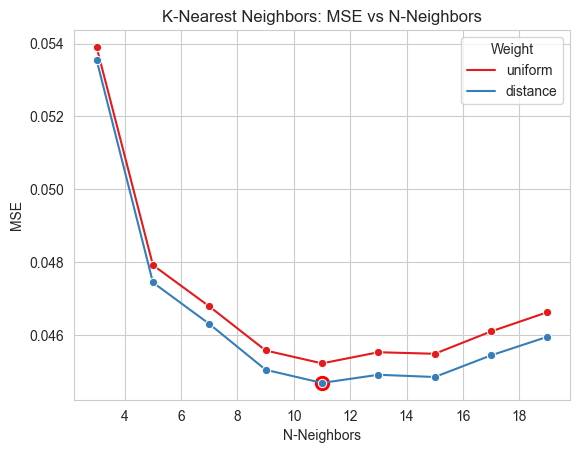

In [23]:
results = pd.DataFrame(results, columns=['Iteration', 'N-Neighbors', 'Weight', 'MSE'])

sns.lineplot(x='N-Neighbors', y='MSE', hue='Weight', data=results, palette='Set1', marker='o')
plt.xlabel('N-Neighbors')
plt.ylabel('MSE')
plt.title('K-Nearest Neighbors: MSE vs N-Neighbors')
plt.scatter(best_n_neighbors, best_mse, color='red', marker='o', s=100)
plt.show()

results.to_csv(results_path + 'k_nearest_neighbors.csv', index=False)

In [24]:
writer.close()